# Intro to  Neural Networks with PyTorch
## Task 4 (Modified) – Autoencoder on CIFAR-10 (reconstruction → SSL → latent space)

**Objective:** To get better separation in the latent space using a standard AE.

**Dataset + Split:** CIFAR-10 from torchvision (60,000 color images (32×32)). 50,000 images for training set with exactly 5000 per class, 10,000 for test set with exactly 1000 per class.

### Define Autoencoder

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, z_dim=128):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1) # Striding => Downsampling
        self.bn1 = nn.BatchNorm2d(32) # 32 channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc = nn.Linear(in_features=64*8*8, out_features=z_dim)

    def forward(self, x): # x is tensor of shape (B, 3, 32, 32), where B –> batch size
        x = F.relu(self.bn1(self.conv1(x))) # (B, 32, 8, 8)
        x = F.relu(self.bn2(self.conv2(x))) # (B, 64, 8, 8)
        x = x.view(x.size(0), -1) # Reshape x to (B, 64*8*8); -1 => remaining dimension is automatically computed
        z = self.fc(x) # Latent space (B, z_dim)
        return z


class Decoder(nn.Module):
    def __init__(self, z_dim=128):
        super().__init__()
        self.fc = nn.Linear(in_features=z_dim, out_features=64*8*8) 
        self.conv1 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.fc(x) # (B, 64*8*8)
        x = x.view(x.size(0), 64, 8, 8) # (B, 64, 8, 8)
        x = F.interpolate(x, scale_factor=2, mode='nearest') # (B, 64, 16, 16)
        x = F.relu(self.bn1(self.conv1(x))) # (B, 32, 16, 16)
        x = F.interpolate(x, scale_factor=2, mode='nearest') # (B, 32, 32, 32)
        x = self.conv2(x) # (B, 3, 32, 32)
        return x


class Autoencoder(nn.Module):
    def __init__(self, z_dim=128, num_classes=10):
        super().__init__()
        self.encoder = Encoder(z_dim=z_dim)
        self.decoder = Decoder(z_dim=z_dim)
        self.classifier = nn.Linear(z_dim, num_classes)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        logits = self.classifier(z)
        return x_hat, z, logits

In [93]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [94]:
# Evaluator function for reconstructed images
@torch.no_grad()
def evaluate_ae(loader, model, recon_criterion, cls_criterion, lambda_cls, device):
    model.eval() # Evaluation mode => Dropout is disabled, BatchNorm uses stored statistics 
    total_loss = 0.0
    total_samples = 0
    total_correct = 0

    for batch in loader:
        if isinstance(batch, dict):
            xb = batch["image"]
            yb = batch["label"]
        else:
                xb, yb = batch
        xb, yb = xb.to(device), yb.to(device)
        x_hat, _, logits = model(xb) # Get reconstructed images
        
        recon_loss = recon_criterion(x_hat, xb) # MSELoss
        cls_loss = cls_criterion(logits, yb)
        loss = recon_loss + cls_loss * lambda_cls

        total_loss += loss.item() * xb.size(0) # x.size(0) => no. of samples in the batch
        total_samples += xb.size(0)

        preds = logits.argmax(dim=1)
        total_correct += (preds == yb).sum().item()

    avg_loss = total_loss / total_samples # Average loss per sample this epoch
    avg_acc = total_correct / total_samples
    
    return avg_loss, avg_acc

### Import and Preprocess Dataset

In [96]:
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# Find mean and standard deviation of dataset
dataset = datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=50000) # Entire training dataset
images, _ = next(iter(loader))
mean, std = images.mean([0, 2, 3]), images.std([0, 2, 3]) # Ignore channel dimension
print(f"Mean: {mean}, Std: {std}")

Mean: tensor([0.4914, 0.4822, 0.4465]), Std: tensor([0.2470, 0.2435, 0.2616])


In [97]:
# Function to get training policy according to selection
def get_train_transform(policy):
    """
    Define transform according to selected policy only for training set
    """
    if policy == "none":
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
    if policy == "light":
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomCrop(size=32, padding=4),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(mean, std),
        ])


# Transform for validation and test sets
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


# Function to make train/val/test splits
def split_train_val_indices(seed=40, val_size=5000):
    rng = np.random.default_rng(seed=seed) # Random number generator object
    indices = np.arange(50000)
    rng.shuffle(indices)
    val_indices = indices[:val_size].tolist()
    train_indices = indices[val_size:].tolist()
    return train_indices, val_indices


# Class to apply dataset augmentation for training set according to selection
class CIFAR10DatasetClass(Dataset):
    def __init__(self, split, indices, policy):
        """
        split => "train" or "val" or "test"
        indices => train_indices or val_indices obtained from split_train_val_indices, or else None
        policy => "none" or "light"
        """
        assert split in ["train", "val", "test"]
        self.split = split
        self.indices = indices
        self.policy = policy
        train_flag = (split != "test")
        self.base_dataset = datasets.CIFAR10(root='./data', train=train_flag, download=True)
        self.class_names = self.base_dataset.classes
        self.train_transform = get_train_transform(policy)
        self.eval_transform = eval_transform

    def __len__(self):
        return len(self.indices) if self.indices is not None else len(self.base_dataset) # Get indices for train/val

    def __getitem__(self, i):
        idx = self.indices[i] if self.indices is not None else i
        image, label = self.base_dataset[idx]
        if self.split == "train":
            image = self.train_transform(image) # Apply augmentation for training data
        else:
            image = self.eval_transform(image) # Apply deterministic transform for val/test data
        return {"image": image, "label": int(label)} # Return dictionary of transformed images and labels        

In [98]:
def get_loaders(policy, seed=40, batch_size=128):
    train_indices, val_indices = split_train_val_indices(seed=seed, val_size=5000)

    # Create dataset class objects
    train_ds = CIFAR10DatasetClass(split="train", indices=train_indices, policy=policy)
    val_ds = CIFAR10DatasetClass(split="val", indices=val_indices, policy="none")
    test_ds = CIFAR10DatasetClass(split="test", indices=None, policy="none")

    # Define loaders
    train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader, train_ds.class_names

### Training

In [100]:
# Function to denormalize images for preview
def denormalize(x, mean, std):
    """
    x is a tensor of shape (B, C, H, W) or (C, H, W)
    """
    if not torch.is_tensor(x):
        raise TypeError("x must be a torch.Tensor")

   # Convert mean and std to tensors on same device and reshape into (1, C, 1, 1)
    mean = mean.to(x.device).view(1, -1, 1, 1) # -1 => infer this dimension
    std = std.to(x.device).view(1, -1, 1, 1)

    # If single image (C, H, W), add batch dim
    was_single = (x.dim() == 3)
    if was_single:
        x = x.unsqueeze(0) # (1, C, H, W) for normalization

    x = x * std + mean # Denormalize
    x = x.clamp(0, 1)

    if was_single:
        x = x.squeeze(0) # Return to original dimension
    return x

In [101]:
# Function to display original and reconstructed images
import matplotlib.pyplot as plt

def show_reconstructions(x, x_hat, mean, std, n=8):
    """
    x and x_hat are images of dimensions (C, H, W)
    n is the number of images that are displayed from the beginning of a batch
    """
    x_dnorm = denormalize(x[:n].detach(), mean, std).cpu() # Denormalize first n images from batch
    xhat_dnorm = denormalize(x_hat[:n].detach(), mean, std).cpu() # Detach => remove from computation because we are not training

    fig, axes = plt.subplots(2, n, figsize=(2*n, 4)) # 2 rows, n columns
    for i in range(n):
        axes[0, i].imshow(x_dnorm[i].permute(1, 2, 0)) # Change dimensions because matplotlib expects (H, W, C)
        axes[0, i].axis("off")
        axes[1, i].imshow(xhat_dnorm[i].permute(1, 2, 0))
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original", fontsize=12)
    axes[1, 0].set_title("Reconstructed", fontsize=12)
    plt.tight_layout()
    plt.show()

In [102]:
import copy

def train_and_validate_ae(model, train_loader, val_loader, recon_criterion, cls_criterion, lambda_cls, optimizer, device, max_epochs=10):
    best_state = None
    best_val_loss = float("inf")

    train_loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []

    for epoch in range(1, max_epochs + 1):
        model.train()
        total_loss = 0.0
        total_samples = 0
        total_correct = 0

        # TRAINING
        for batch in train_loader:
            if isinstance(batch, dict):
                xb = batch["image"]
                yb = batch["label"]
            else:
                xb, yb = batch
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True) # Reset gradients from previous step
            
            x_hat, z, logits = model(xb) # Forward pass
            
            loss_recon = recon_criterion(x_hat, xb)
            loss_cls = cls_criterion(logits, yb)
            loss = loss_recon + loss_cls * lambda_cls
            
            loss.backward() # Backpropagation
            optimizer.step() # Update weights using optimizer

            total_loss += loss.item() * xb.size(0)
            total_samples += xb.size(0)
            
            preds = logits.argmax(dim=1)
            total_correct += (preds == yb).sum().item()

        train_loss = total_loss / total_samples
        train_acc = total_correct / total_samples

        # VALIDATION
        val_loss, val_acc = evaluate_ae(val_loader, model, recon_criterion, cls_criterion, lambda_cls, device)

        # For plotting
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

        # Checkpoint if val loss reduces
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

        # To display validation reconstruction images every 5 epochs
        if epoch % 5 == 0:
            model.eval()
            batch = next(iter(val_loader))
            if isinstance(batch, dict):
                xb_show = batch["image"]
            else:
                xb_show, _ = batch
            xb_show = xb_show.to(device)

            with torch.no_grad():
                x_hat_show, _, _ = model(xb_show)
            show_reconstructions(xb_show, x_hat_show, mean, std, n=8)

    if best_state is not None:
        model.load_state_dict(best_state)

    return train_loss, best_val_loss, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist    


Policy: none

Epoch 01 | train_loss=0.3799 | val_loss=0.2666
Epoch 02 | train_loss=0.2365 | val_loss=0.2227
Epoch 03 | train_loss=0.2072 | val_loss=0.2051
Epoch 04 | train_loss=0.1923 | val_loss=0.2010
Epoch 05 | train_loss=0.1867 | val_loss=0.2021


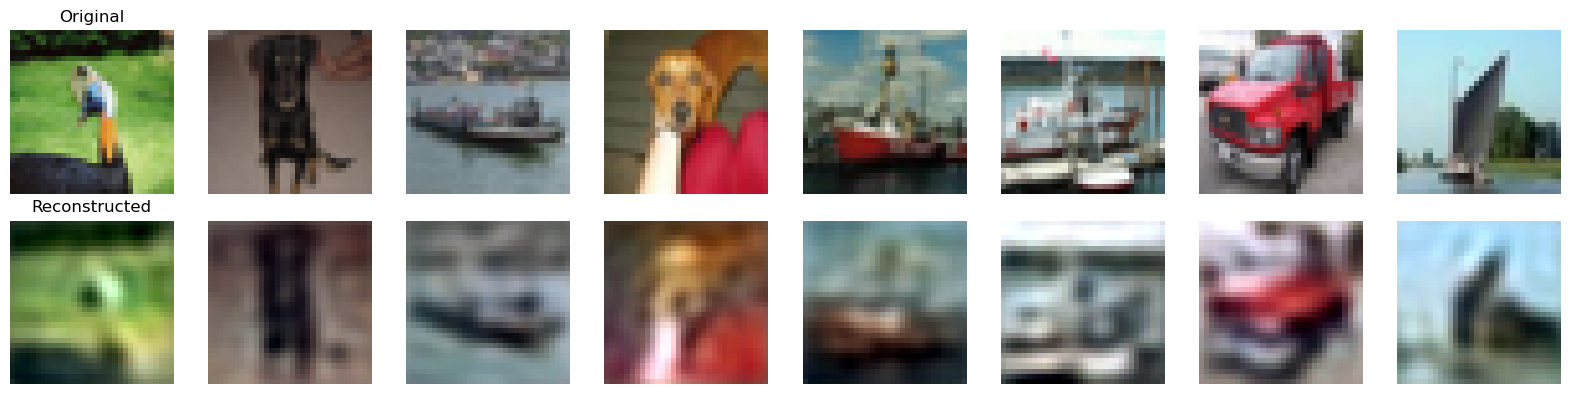

Epoch 06 | train_loss=0.1775 | val_loss=0.1998
Epoch 07 | train_loss=0.1737 | val_loss=0.1978
Epoch 08 | train_loss=0.1699 | val_loss=0.2176
Epoch 09 | train_loss=0.1646 | val_loss=0.1955
Epoch 10 | train_loss=0.1606 | val_loss=0.2024


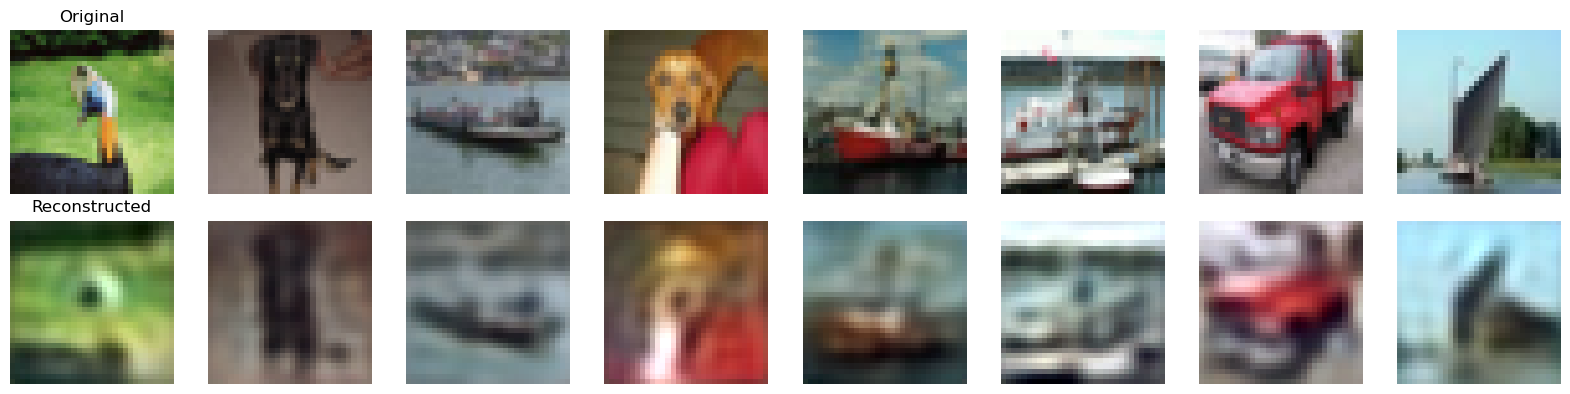


Test Recon Loss=0.1963 | Best Val Loss=0.1955

Policy: light

Epoch 01 | train_loss=0.4307 | val_loss=0.2791
Epoch 02 | train_loss=0.2709 | val_loss=0.2377
Epoch 03 | train_loss=0.2401 | val_loss=0.2215
Epoch 04 | train_loss=0.2257 | val_loss=0.2101
Epoch 05 | train_loss=0.2169 | val_loss=0.2083


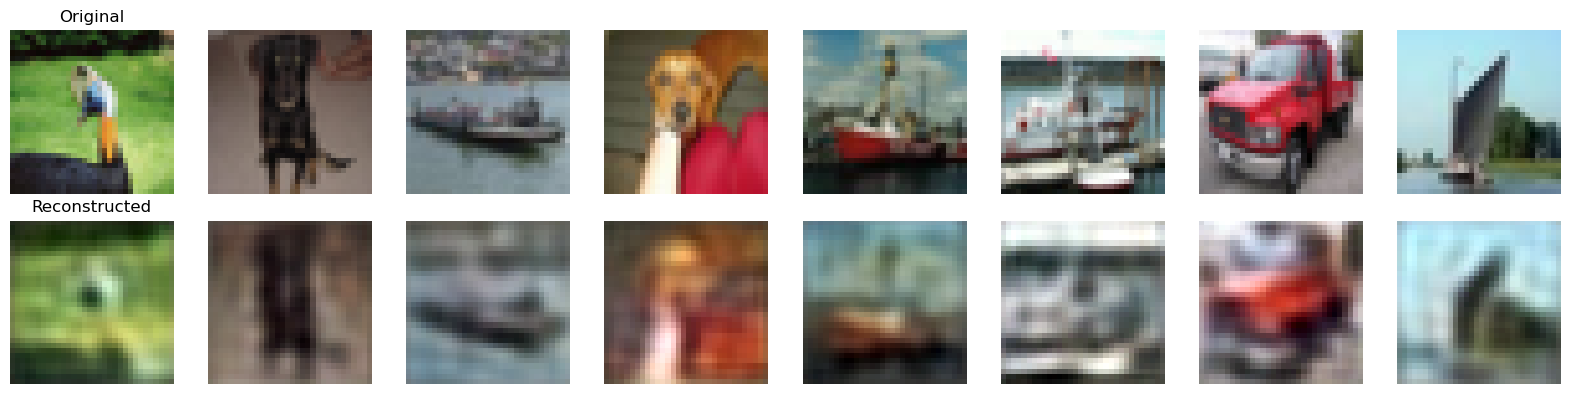

Epoch 06 | train_loss=0.2139 | val_loss=0.2030
Epoch 07 | train_loss=0.2079 | val_loss=0.2039
Epoch 08 | train_loss=0.2039 | val_loss=0.1988
Epoch 09 | train_loss=0.2020 | val_loss=0.1953
Epoch 10 | train_loss=0.2005 | val_loss=0.1926


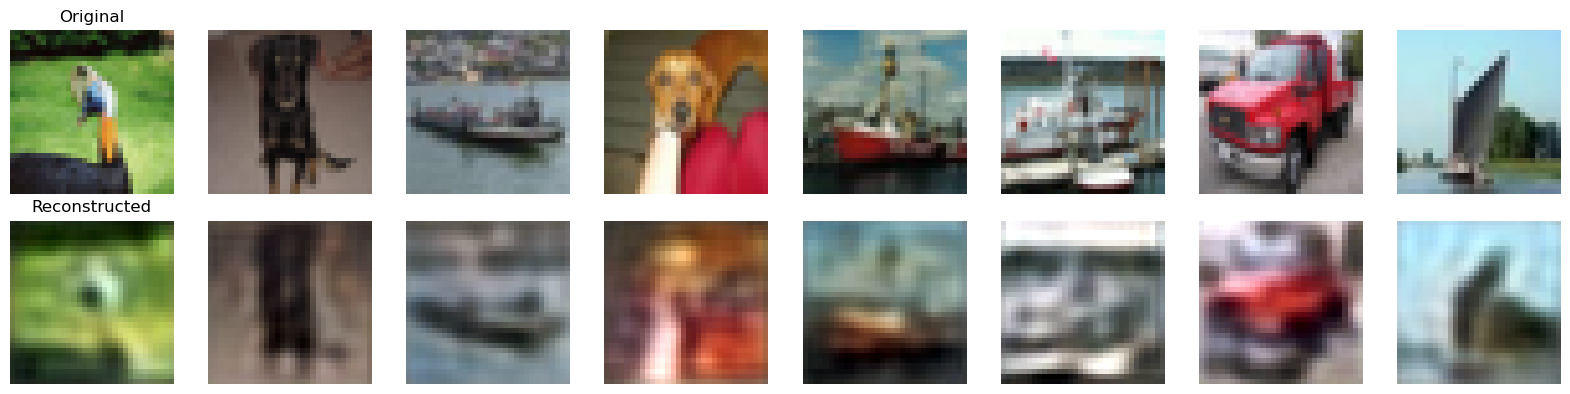


Test Recon Loss=0.1936 | Best Val Loss=0.1926


In [103]:
# Training, validation, testing for all policies 
policies = ["none", "light"]
results = []
loss_curves = {}
cls_acc_curves = {}

for policy in policies:
    print("\n" + "="*60)
    print(f"Policy: {policy}")
    print("="*60 + "\n")

    train_loader, val_loader, test_loader, _ = get_loaders(policy, seed=40, batch_size=128)

    model = Autoencoder(z_dim=128).to(device)
    recon_criterion = nn.MSELoss()
    cls_criterion = nn.CrossEntropyLoss()
    lambda_cls = 0.1
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    # TRAIN AND VALIDATE
    last_train_loss, best_val_loss, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_and_validate_ae(
        model, train_loader, val_loader, recon_criterion, cls_criterion, lambda_cls, optimizer, device, max_epochs=10
    )
    torch.save(model.state_dict(), f"ae_{policy}_best.pth")
    
    # TESTING
    test_loss, test_acc = evaluate_ae(test_loader, model, recon_criterion, cls_criterion, lambda_cls, device)

    results.append((policy, last_train_loss, best_val_loss, test_loss, test_acc))
    loss_curves[policy] = (train_loss_hist, val_loss_hist)
    cls_acc_curves[policy] = (train_acc_hist, val_acc_hist)

    print(f"\nTest Recon Loss={test_loss:.4f} | Best Val Loss={best_val_loss:.4f}")

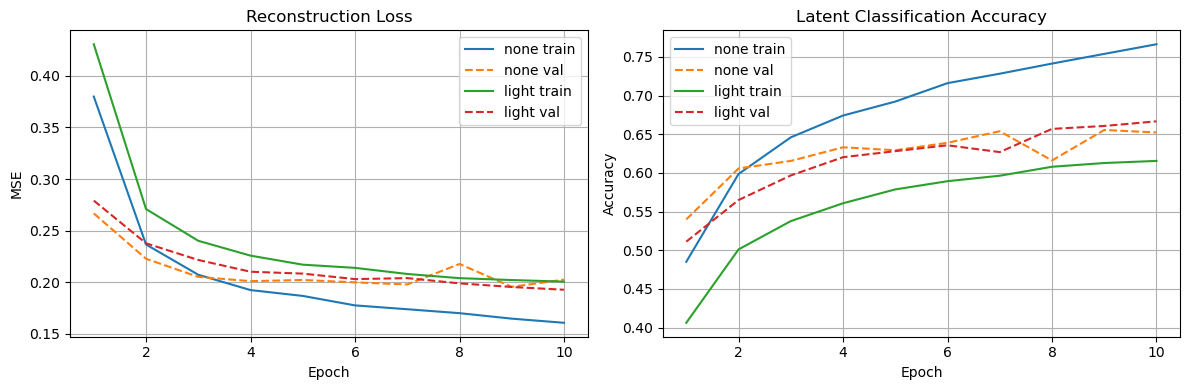

In [118]:
# Plot total loss and classification accuracy

policies = list(loss_curves.keys()) # Get policies 

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# Loss
ax = axes[0]
for policy in policies:
    train_loss, val_loss = loss_curves[policy]
    epochs = range(1, len(train_loss) + 1)

    ax.plot(epochs, train_loss, label=f"{policy} train")
    ax.plot(epochs, val_loss,  linestyle="--", label=f"{policy} val")

ax.set_title("Reconstruction Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
ax.legend()
ax.grid(True)

# Classification accuracy
ax = axes[1]
for policy in policies:
    train_acc, val_acc = cls_acc_curves[policy]
    epochs = range(1, len(train_acc) + 1)

    ax.plot(epochs, train_acc, label=f"{policy} train")
    ax.plot(epochs, val_acc,  linestyle="--", label=f"{policy} val")

ax.set_title("Latent Classification Accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

## Latent Space Representation

In [127]:
# To get latent space from loader
@torch.no_grad()
def collect_latents(ae, loader, device, max_batches=100): # max_batches prevents t-SNE from becoming too slow
    ae.eval()
    Z_list, Y_list = [], []

    for i, batch in enumerate(loader):
        if i >= max_batches: # Stop at max_batches
            break

        x = batch["image"].to(device)
        y = batch["label"] # Only used for coloring plot

        _, z, _ = ae(x)
        Z_list.append(z.cpu()) # Numpy only works on CPU so move to CPU
        Y_list.append(y.cpu())

    Z = torch.cat(Z_list, dim=0).numpy() # Concatenate all batches
    Y = torch.cat(Y_list, dim=0).numpy()
    
    return Z, Y

### ae_none_best.pth

In [130]:
# Load ae
ae_none = Autoencoder(z_dim=128).to(device)
ae_none.load_state_dict(torch.load("ae_none_best.pth", map_location=device))

# Freeze ae
for p in ae_none.parameters():
    p.requires_grad = False
ae_none.eval() # Evaluation mode

# Take test loader so no augmentation
_, _, test_loader, _ = get_loaders(policy="none")

Z_none, Y_none = collect_latents(ae_none, test_loader, device)

In [132]:
from sklearn.manifold import TSNE

# Create tsne object
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter_without_progress=1000,
    random_state=42,
)

# Transform latent space
Z_none_2d = tsne.fit_transform(Z_none)

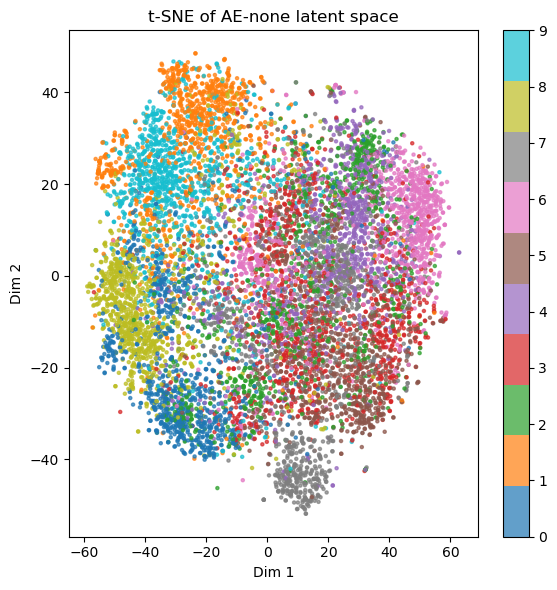

In [134]:
# Plot
plt.figure(figsize=(6, 6))
scatter = plt.scatter(
    Z_none_2d[:, 0],
    Z_none_2d[:, 1],
    c=Y_none,
    cmap="tab10",
    s=5,
    alpha=0.7,
)

plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE of AE-none latent space")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

### ae_light_best.pth

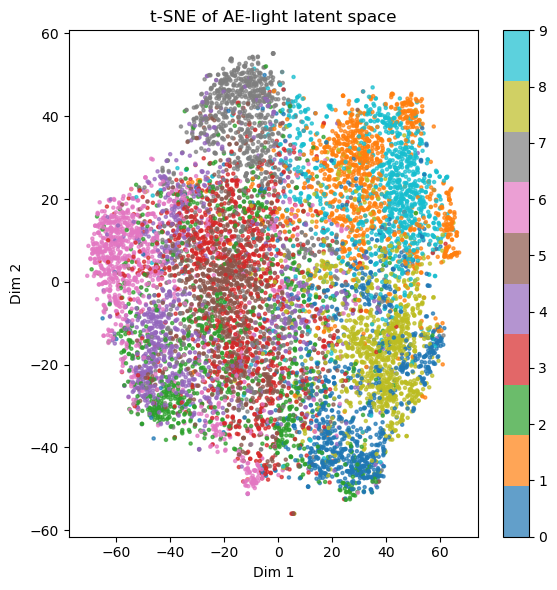

In [137]:
# Load ae
ae_light = Autoencoder(z_dim=128).to(device)
ae_light.load_state_dict(torch.load("ae_light_best.pth", map_location=device))

# Freeze ae
for p in ae_light.parameters():
    p.requires_grad = False
ae_light.eval() # Evaluation mode

# Get latents
Z_light, Y_light = collect_latents(ae_light, test_loader, device)

# Reduce dimensions using same tSNE object
Z_light_2d = tsne.fit_transform(Z_light)

# Plot
plt.figure(figsize=(6, 6))
scatter = plt.scatter(
    Z_light_2d[:, 0],
    Z_light_2d[:, 1],
    c=Y_none,
    cmap="tab10",
    s=5,
    alpha=0.7,
)

plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE of AE-light latent space")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

## Latent Interpolation

In [159]:
# Function to display latent interpolation
def show_latent_interpolation(x_hat, mean, std, n=8):
    """
    x_hat is an image of dimensions (C, H, W)
    n is the number of images that are displayed from the beginning of a batch
    """
    x_hat_dnorm = denormalize(x_hat[:n].detach(), mean, std).cpu() # Denormalize first n images from batch

    fig, axes = plt.subplots(1, n, figsize=(2*n, 4)) # 1 rows, n columns
    for i in range(n):
        axes[i].imshow(x_hat_dnorm[i].permute(1, 2, 0)) # Change dimensions because matplotlib expects (H, W, C)
        axes[i].axis("off")

    axes[0].set_title("Latent Interpolation", fontsize=12)
    plt.tight_layout()
    plt.show()

### ae_none_best.pth

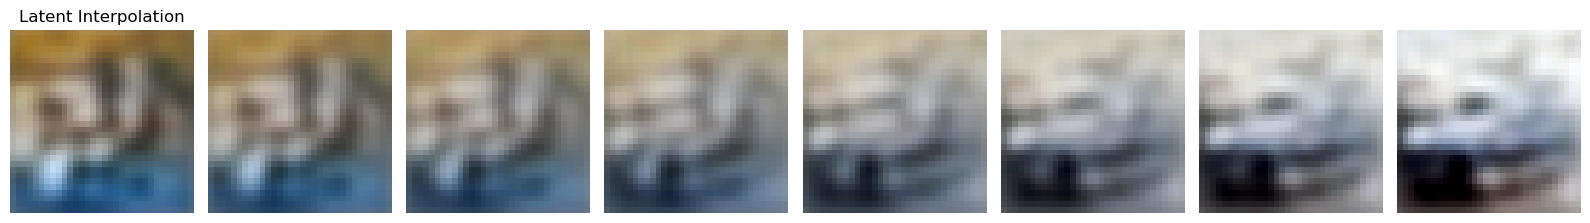

In [161]:
# Pick 2 images from test set
batch = next(iter(test_loader))
x = batch["image"].to(device)

x1 = x[0:1]
x2 = x[1:2]

# Encode to latent vectors
with torch.no_grad():
    _, z1, _ = ae_none(x1)
    _, z2, _ = ae_none(x2)

# Interpolate in latent space
alphas = torch.linspace(0, 1, steps=8).to(device) # Creates straight line from z1 –> z2
z_interp = [(1 - a) * z1 + a * z2 for a in alphas]
z_interp = torch.cat(z_interp, dim=0)

# Decode interpolated latents
with torch.no_grad():
    x_hat_interp = ae_none.decoder(z_interp)

show_latent_interpolation(x_hat_interp, mean, std, n=8)

### ae_light_best.pth

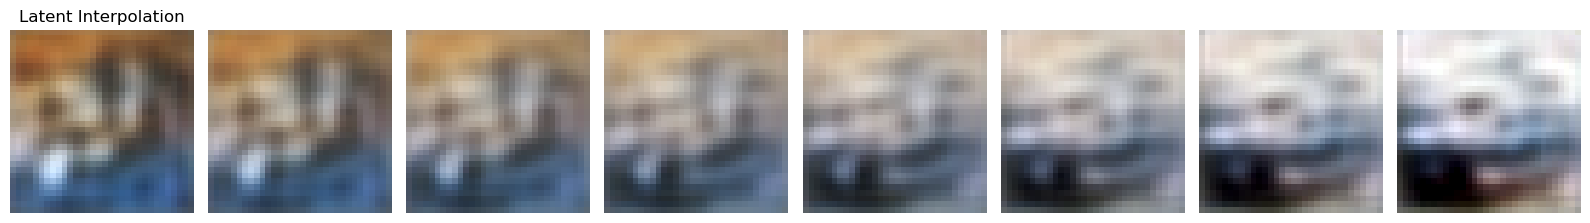

In [165]:
# Pick 2 images from test set
batch = next(iter(test_loader))
x = batch["image"].to(device)

x1 = x[0:1]
x2 = x[1:2]

# Encode to latent vectors
with torch.no_grad():
    _, z1, _ = ae_light(x1)
    _, z2, _ = ae_light(x2)

# Interpolate in latent space
alphas = torch.linspace(0, 1, steps=8).to(device) # Creates straight line from z1 –> z2
z_interp = [(1 - a) * z1 + a * z2 for a in alphas]
z_interp = torch.cat(z_interp, dim=0)

# Decode interpolated latents
with torch.no_grad():
    x_hat_interp = ae_light.decoder(z_interp)

show_latent_interpolation(x_hat_interp, mean, std, n=8)